__Importing necessary libraries__

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
plt.style.use("seaborn")

__Downloading data from yahoo finance__

In [3]:
data = yf.download(tickers = 'SPY', start = '2012-03-11',end = '2022-07-10')
data.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,137.550003,137.759995,137.089996,137.580002,111.786369,104003500
2012-03-13,138.320007,140.130005,138.089996,140.059998,113.801407,184090500
2012-03-14,140.100006,140.449997,139.479996,139.910004,113.679527,145163600
2012-03-15,140.119995,140.779999,139.759995,140.720001,114.337685,165118500
2012-03-16,140.360001,140.479996,140.000000,140.300003,114.496017,152893500
2012-03-19,140.210007,141.279999,140.110001,140.850006,114.944862,125291100
2012-03-20,140.050003,140.610001,139.639999,140.440002,114.610252,121729700
2012-03-21,140.520004,140.649994,139.919998,140.210007,114.422585,122388400
2012-03-22,139.179993,139.550003,138.740005,139.199997,113.598305,135216700


__Creating features for LSTM__

In [4]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20) # fast moving average
data['EMAM']=ta.ema(data.Close, length=100) # medium moving average
data['EMAS']=ta.ema(data.Close, length=150) # long moving average

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Date'], axis=1, inplace=True)

In [5]:
data_set = data.iloc[:, 0:12]
pd.set_option('display.max_columns', None)

data_set.head(10)

,Open,High,Low,Close,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,144.279999,144.490005,143.330002,143.360001,118.227119,46.104329,144.482149,140.808973,138.420933,-25.620438,0,117.839569
1,143.460007,143.949997,142.580002,142.889999,117.839569,43.849764,144.330516,140.850181,138.480126,-24.409035,0,118.820961
2,143.229996,144.229996,142.770004,144.080002,118.820961,50.426130,144.306657,140.914138,138.554297,-24.735001,0,120.024994
3,144.759995,145.639999,144.660004,145.539993,120.024994,57.040115,144.424118,141.005739,138.646823,-25.070671,0,120.569328
4,145.639999,146.320007,145.419998,146.199997,120.569328,59.647697,144.593249,141.108596,138.746865,-25.564102,0,120.255905
5,145.820007,146.520004,145.330002,145.820007,120.255905,57.494950,144.710083,141.201891,138.840549,-27.298096,0,118.251907
6,145.550003,145.559998,143.050003,143.389999,118.251907,46.096061,144.584361,141.245220,138.900806,-24.881584,0,118.268410
7,143.149994,143.669998,142.279999,143.410004,118.268410,46.190158,144.472517,141.288087,138.960531,-25.232719,0,116.627281
8,141.860001,142.059998,140.830002,141.419998,116.627281,38.944284,144.181801,141.290699,138.993107,-25.632576,0,116.297417
9,141.929993,142.100006,140.800003,141.020004,116.297417,37.671608,143.880678,141.285339,139.019953,-25.384430,0,116.635574


__Normalizing data using MinMax scaler from scikit learn library__

There are two ways to normalize the data:
 1) using MinMaxScaler

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled_1 = sc.fit_transform(data_set)
print(data_set_scaled_1)

[[0.02440873 0.02329034 0.02528124 ... 0.1531361  0.         0.01655479]
 [0.02202031 0.02171822 0.02308415 ... 0.1815834  0.         0.01929478]
 [0.02135035 0.02253338 0.02364075 ... 0.17392876 0.         0.02265637]
 ...
 [0.69899804 0.7146933  0.69779704 ... 0.70376151 0.         0.7483169 ]
 [0.71714431 0.72601818 0.71742445 ... 0.76670422 1.         0.76420408]
 [0.72591167 0.73754688 0.72817551 ... 0.70876726 0.         0.76331848]]


2) using min and std of dataframe

In [7]:
mu, std = data.mean(), data.std() # train set parameters (mu, std) for standardization

In [8]:
data_set_2  = (data - mu) / std
data_set_2.describe()

,Open,High,Low,Close,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
count,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03,2.449000e+03
mean,-3.249522e-16,-3.249522e-16,-4.642174e-17,4.642174e-17,9.284348e-17,6.557071e-16,-4.642174e-17,-3.713739e-16,3.249522e-16,-4.642174e-17,2.321087e-17,1.856870e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.505023e+00,-1.504163e+00,-1.513322e+00,-1.508100e+00,-1.444166e+00,-3.520760e+00,-1.455215e+00,-1.419172e+00,-1.436172e+00,-1.668631e+00,-8.840666e-02,-1.445226e+00
25%,-7.412831e-01,-7.411556e-01,-7.455744e-01,-7.397113e-01,-7.584756e-01,-6.768414e-01,-7.430009e-01,-7.027991e-01,-6.896436e-01,-8.055643e-01,-8.840666e-02,-7.586525e-01
50%,-2.194292e-01,-2.222272e-01,-2.221581e-01,-2.164242e-01,-2.234634e-01,1.271332e-01,-2.137804e-01,-2.145446e-01,-2.193263e-01,-2.957679e-01,-8.840666e-02,-2.243313e-01
75%,4.464850e-01,4.591122e-01,4.354584e-01,4.446742e-01,4.760814e-01,7.411797e-01,4.276958e-01,4.367544e-01,4.766714e-01,6.714256e-01,-8.840666e-02,4.903605e-01
max,2.493257e+00,2.469237e+00,2.494605e+00,2.476081e+00,2.440022e+00,2.893866e+00,2.411008e+00,2.351292e+00,2.325602e+00,4.203333e+00,1.130675e+01,2.438632e+00


In [9]:
data_set_2=data_set_2.to_numpy()
data_set_2

array([[-1.40743009, -1.41162131, -1.41199667, ..., -0.76942097,
        -0.08840666, -1.38092971],
       [-1.41697965, -1.41786799, -1.42080246, ..., -0.60237945,
        -0.08840666, -1.37028798],
       [-1.41965835, -1.41462904, -1.41857163, ..., -0.64732721,
        -0.08840666, -1.35723204],
       ...,
       [ 1.28976661,  1.3355995 ,  1.28339744, ...,  2.46383148,
        -0.08840666,  1.46113037],
       [ 1.3623205 ,  1.38059779,  1.36206266, ...,  2.83342877,
        11.30674638,  1.52283392],
       [ 1.39737486,  1.42640591,  1.40515214, ...,  2.49322505,
        -0.08840666,  1.51939437]])

__Creating labels and target values__

In [10]:

# multiple feature from data provided to the model
X = []
backcandles = 20
feature_cols = 9
for j in range(feature_cols): # first 9 columns are features
    X.append([])
    for i in range(backcandles, data_set_2.shape[0]):
        X[j].append(data_set_2[i-backcandles:i, j])
X = np.array(X)
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_2[backcandles:,-3]) # the target columns is used for training 
y=np.reshape(yi,(len(yi),1))


__Split data into train test sets__

In [11]:
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]


__Implementing LSTM__

In [13]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
np.random.seed(10)

lstm_input = Input(shape=(backcandles, feature_cols), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
117/117 [==============================] - 10s 50ms/step - loss: 0.1116 - val_loss: 0.5532
Epoch 2/30
117/117 [==============================] - 5s 43ms/step - loss: 0.1013 - val_loss: 0.4805
Epoch 3/30
117/117 [==============================] - 5s 45ms/step - loss: 0.0907 - val_loss: 0.4861
Epoch 4/30
117/117 [==============================] - 5s 43ms/step - loss: 0.0834 - val_loss: 0.3022
Epoch 5/30
117/117 [==============================] - 5s 44ms/step - loss: 0.0805 - val_loss: 0.3753
Epoch 6/30
117/117 [==============================] - 5s 43ms/step - loss: 0.0727 - val_loss: 0.5307
Epoch 7/30
117/117 [==============================] - 5s 43ms/step - loss: 0.0731 - val_loss: 0.3416
Epoch 8/30
117/117 [==============================] - 5s 45ms/step - loss: 0.0639 - val_loss: 0.4458
Epoch 9/30
117/117 [==============================] - 5s 40ms/step - loss: 0.0658 - val_loss: 0.3795
Epoch 10/30
117/117 [==============================] - 5s 45ms/step - loss: 0.0653 - val_l

In [14]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

16/16 [==============================] - 2s 16ms/step
[0.4984439] [1.38800166]
[0.49074137] [1.16246021]
[0.48035133] [1.45590354]
[0.46899801] [1.23958203]
[0.45492935] [1.12693965]
[0.44432804] [0.51224588]
[0.43226573] [1.32288555]
[0.43891364] [1.08054116]
[0.43751425] [1.10945079]
[0.43988925] [1.04056843]


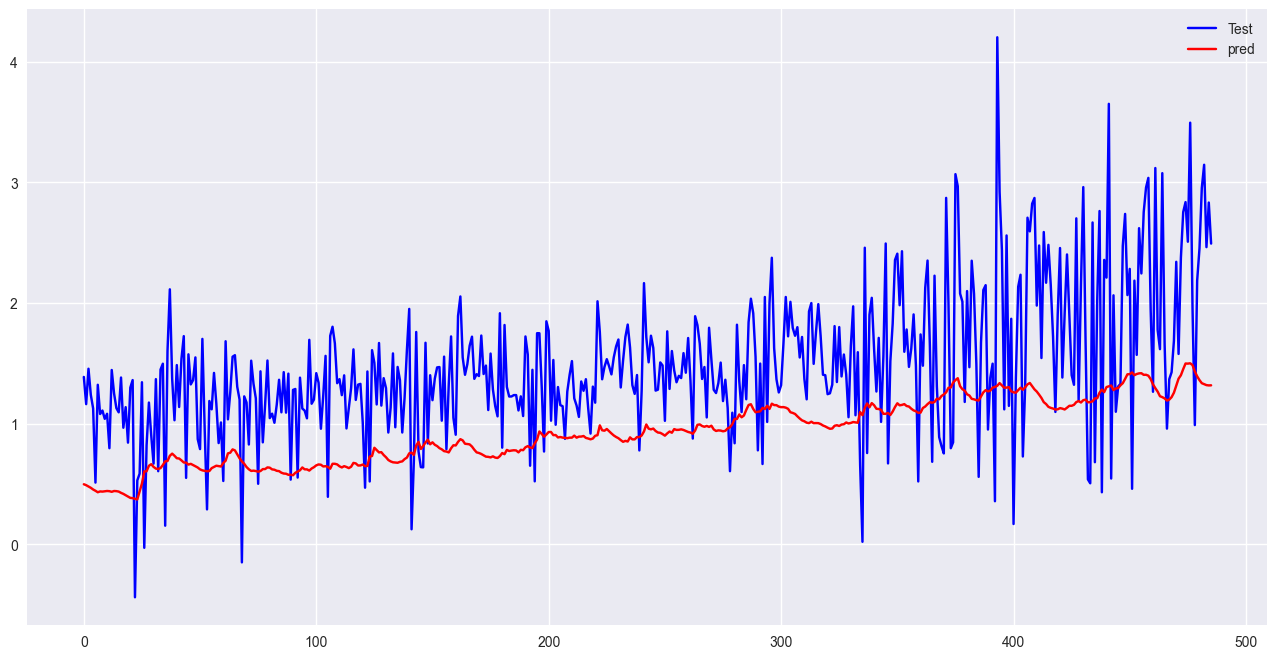

In [15]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()